# (Frustratingly Easy) LLaVA OneVision Tutorial

We know that it's always beneficial to have a unified interface for different tasks. So we are trying to unify the interface for image, text, image-text interleaved, and video input. And in this tutorial, we aim to provide the most straightforward way to use our model. 

We use our 0.5B version as an example. This could be running on a GPU with 4GB memory. And with the following examples, you could see it's surprisingly have promising performance on understanding the image, interleaved image-text, and video. Tiny but mighty!

The same code could be used for 7B model as well.

## Inference Guidance

First please install our repo with code and environments: pip install git+https://github.com/LLaVA-VL/LLaVA-NeXT.git

Here is a quick inference code using [lmms-lab/qwen2-0.5b-si](https://huggingface.co/lmms-lab/llava-onevision-qwen2-0.5b-si) as an example. You will need to install `flash-attn` to use this code snippet. If you don't want to install it, you can set `attn_implementation=None` when load_pretrained_model

### Image Input
Tackling the single image input with LLaVA OneVision is pretty straightforward.

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

import sys
import warnings

warnings.filterwarnings("ignore")
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-si"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
cache_dir = "/dpc/kunf0097/cache/models"
tokenizer, model, image_processor, max_length = load_pretrained_model(model_path, None, model_name, device_map=device_map, cache_dir=cache_dir)  # Add any other thing you want to pass in llava_model_args

model.eval()

In [ ]:


url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "qwen_1_5"  # Make sure you use correct chat template for different models
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]


cont = model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs)

You could use the following code to make it streaming in terminal, this would be pretty useful when creating a chatbot.

In [ ]:
from threading import Thread
from transformers import TextIteratorStreamer
import json

url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "qwen_1_5"
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]

max_context_length = getattr(model.config, "max_position_embeddings", 2048)
num_image_tokens = question.count(DEFAULT_IMAGE_TOKEN) * model.get_vision_tower().num_patches

streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True, timeout=15)

max_new_tokens = min(4096, max_context_length - input_ids.shape[-1] - num_image_tokens)

if max_new_tokens < 1:
    print(
        json.dumps(
            {
                "text": question + "Exceeds max token length. Please start a new conversation, thanks.",
                "error_code": 0,
            }
        )
    )
else:
    gen_kwargs = {
        "do_sample": False,
        "temperature": 0,
        "max_new_tokens": max_new_tokens,
        "images": image_tensor,
        "image_sizes": image_sizes,
    }

    thread = Thread(
        target=model.generate,
        kwargs=dict(
            inputs=input_ids,
            streamer=streamer,
            **gen_kwargs,
        ),
    )
    thread.start()

    generated_text = ""
    for new_text in streamer:
        generated_text += new_text
        print(generated_text, flush=True)
        # print(json.dumps({"text": generated_text, "error_code": 0}), flush=True)

    print("Final output:", generated_text)

### Image-Text Interleaved Input

Now switching to our onevision model for more complex tasks. You should start to use `llava-onevision-qwen2-0.5b-ov` for image-text interleaved input and video input.

Processing image-text interleaved input is a bit more complicated. But following the code below should work.

In [ ]:
# Load model
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
llava_model_args = {
        "multimodal": True,
    }
overwrite_config = {}
overwrite_config["image_aspect_ratio"] = "pad"
llava_model_args["overwrite_config"] = overwrite_config
tokenizer, model, image_processor, max_length = load_pretrained_model(model_path, None, model_name, device_map=device_map, **llava_model_args)

model.eval()

# Load two images
url1 = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
url2 = "https://raw.githubusercontent.com/haotian-liu/LLaVA/main/images/llava_logo.png"

image1 = Image.open(requests.get(url1, stream=True).raw)
image2 = Image.open(requests.get(url2, stream=True).raw)

images = [image1, image2]
image_tensors = process_images(images, image_processor, model.config)
image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]

# Prepare interleaved text-image input
conv_template = "qwen_1_5"
question = f"{DEFAULT_IMAGE_TOKEN} This is the first image. Can you describe what you see?\n\nNow, let's look at another image: {DEFAULT_IMAGE_TOKEN}\nWhat's the difference between these two images?"

conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size for image in images]

# Generate response
cont = model.generate(
    input_ids,
    images=image_tensors,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs[0])

### Video Input

Now let's try video input. It's the same as image input, but you need to pass in a list of video frames. And remember to set the `<image>` token only once in the prompt, e.g. "<image>\nWhat is shown in this video?", not "<image>\n<image>\n<image>\nWhat is shown in this video?". Since we trained on this format, it's important to keep the format consistent.

In [ ]:
import torch
torch.cuda.device_count()

In [ ]:
from llava.model import *
LlavaQwenForCausalLM.from_pretrained(model_path)

In [2]:
from llava.model.builder import load_pretrained_model, load_pretrained_model_simplified, connect_parent_lm_head
from llava.mm_utils import tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX
from llava.conversation import conv_templates

import numpy as np
import copy
import warnings
from decord import VideoReader, cpu

warnings.filterwarnings("ignore")

model_base =  None# "amew0/llava-qwen-ov-s2-1016_100248"
model_name = "llava_qwen"
device_map = {"":0}
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov" # "/dpc/kunf0097/out/checkpoints/lora-llava-qwen-ov-s3-1020_154802"
tokenizer, model, image_processor, max_length = load_pretrained_model_simplified(model_path, model_base, model_name, device_map=device_map, attn_implementation=None)

{'device_map': {'': 0}, 'torch_dtype': torch.float16}


You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384
Model Class: LlavaQwenForCausalLM


In [ ]:
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
model_name = "llava_qwen"
model = connect_parent_lm_head(model, model_path, model_name, device_map)


In [ ]:
import matplotlib.pyplot as plt
a = model.lm_head.weight.data.cpu().numpy()
b = a[::a.shape[0]//100,::a.shape[1]//100]
plt.imshow(b, cmap="gray")
plt.colorbar()
plt.show()

In [6]:
# save model and tokenizer
save_path = "/dpc/kunf0097/.cache/huggingface/hub/llava-qwen-ov-s3-1020_154802"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

In [13]:
ex =  {
        "id": "68fdc346-fa5a-45d2-8309-17269f819213",
        "video": "/dpc/kunf0097/data/hwid12/68fdc346-fa5a-45d2-8309-17269f819213.mp4",
        "conversations": [
            {
                "from": "human",
                "value": "<image>\nWhat is happening here?"
            },
            {
                "from": "gpt",
                "value": "Accident Severity: 3 (Motorcycle accidents can be severe due to rider vulnerability.)\nCongestion Severity: 3 (Possible road blockages causing moderate disruption in traffic.)\nCause: Motorcycle collisions often occur due to sudden lane changes or poor visibility by the other vehicle."
            }
        ]
    }

In [4]:

# Function to extract frames from video
def load_video(video_path, max_frames_num):
    if type(video_path) == str:
        vr = VideoReader(video_path, ctx=cpu(0))
    else:
        vr = VideoReader(video_path[0], ctx=cpu(0))
    total_frame_num = len(vr)
    uniform_sampled_frames = np.linspace(0, total_frame_num - 1, max_frames_num, dtype=int)
    frame_idx = uniform_sampled_frames.tolist()
    spare_frames = vr.get_batch(frame_idx).asnumpy()
    return spare_frames  # (frames, height, width, channels)


# Load and process video
video_path = "/dpc/kunf0097/data/hwid12/68fdc346-fa5a-45d2-8309-17269f819213.mp4" #ex["video"]
video_frames = load_video(video_path, 16)
print(video_frames.shape) # (16, 1024, 576, 3)
image_tensors = [] 
frames = image_processor.preprocess(video_frames, return_tensors="pt")["pixel_values"].half().cuda()
image_tensors.append(frames)

(16, 720, 1280, 3)


In [18]:
image_tensors[0].shape

torch.Size([16, 3, 384, 384])

In [20]:

# Function to extract frames from video
def load_video(video_path, max_frames_num):
    if type(video_path) == str:
        vr = VideoReader(video_path, ctx=cpu(0))
    else:
        vr = VideoReader(video_path[0], ctx=cpu(0))
    total_frame_num = len(vr)
    uniform_sampled_frames = np.linspace(0, total_frame_num - 1, max_frames_num, dtype=int)
    frame_idx = uniform_sampled_frames.tolist()
    spare_frames = vr.get_batch(frame_idx).asnumpy()
    return spare_frames  # (frames, height, width, channels)


# Load and process video
video_path = "docs/jobs.mp4" #ex["video"]
video_frames = load_video(video_path, 16)
print(video_frames.shape) # (16, 1024, 576, 3)
image_tensors = [] 
frames = image_processor.preprocess(video_frames, return_tensors="pt")["pixel_values"].half().cuda()
image_tensors.append(frames)

# # Prepare conversation input
# conv_template = "qwen_1_5"
# from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
# question = f"{DEFAULT_IMAGE_TOKEN}\nDescribe what's happening in this video."

# conv = copy.deepcopy(conv_templates[conv_template])
# conv.append_message(conv.roles[0], question)
# conv.append_message(conv.roles[1], None)
# prompt_question = conv.get_prompt()

# input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(model.device)
# image_sizes = [frame.size for frame in video_frames]

# # Generate response
# cont = model.generate(
#     input_ids,
#     images=image_tensors,
#     image_sizes=image_sizes,
#     do_sample=False,
#     temperature=0,
#     max_new_tokens=4096,
#     modalities=["video"],
# )
# text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
# print(text_outputs[0])

# instruction = ex["conversations"][0]["value"]
# context = ex["conversations"][1]["value"]
# conv = copy.deepcopy(conv_templates[conv_template])
# conv.append_message(conv.roles[0], instruction)
# # conv.append_message(conv.roles[0], context)
# conv.append_message(conv.roles[1], None)
# prompt_question = conv.get_prompt()
# print(prompt_question)

# input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(model.device)
# image_sizes = [frame.size for frame in video_frames]
# print(image_sizes)


(16, 1024, 576, 3)
The!! video!!!!!!!!!!!


In [3]:
# from operator import attrgetter
# from llava.model.builder import load_pretrained_model
# from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
# from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
# from llava.conversation import conv_templates, SeparatorStyle

# import torch
# import cv2
# import numpy as np
# from PIL import Image
# import requests
# import copy
# import warnings
# from decord import VideoReader, cpu

# warnings.filterwarnings("ignore")
# # Load the OneVision model
# pretrained = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
# model_name = "llava_qwen"
# device = "cuda"
# device_map = "auto"
# llava_model_args = {
#     "multimodal": True,
#     "attn_implementation":None
# }
# tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map, **llava_model_args)

# model.eval()


# Function to extract frames from video
def load_video(video_path, max_frames_num):
    if type(video_path) == str:
        vr = VideoReader(video_path, ctx=cpu(0))
    else:
        vr = VideoReader(video_path[0], ctx=cpu(0))
    total_frame_num = len(vr)
    uniform_sampled_frames = np.linspace(0, total_frame_num - 1, max_frames_num, dtype=int)
    frame_idx = uniform_sampled_frames.tolist()
    spare_frames = vr.get_batch(frame_idx).asnumpy()
    return spare_frames  # (frames, height, width, channels)


# Load and process video
video_path = "docs/jobs.mp4"
video_frames = load_video(video_path, 16)
print(video_frames.shape) # (16, 1024, 576, 3)
image_tensors = []
frames = image_processor.preprocess(video_frames, return_tensors="pt")["pixel_values"].half().cuda()
image_tensors.append(frames)

# Prepare conversation input
conv_template = "qwen_1_5"
question = f"{DEFAULT_IMAGE_TOKEN}\n\nDescribe what's happening in this video."

conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()
print(prompt_question)

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [frame.size for frame in video_frames]

# Generate response
cont = model.generate(
    input_ids,
    images=image_tensors,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=40000,
    modalities=["video"],
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs[0])

(16, 1024, 576, 3)
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<image>

Describe what's happening in this video.<|im_end|>
<|im_start|>assistant

The video features a person standing on a stage, dressed in dark clothing and holding a smartphone. The background is dark with a large hand reaching towards the screen behind them. As the hand reaches out, it appears to be interacting with the phone, which then zooms into the screen displaying an image of a new iPhone. The text overlay reads 'Is this new?' followed by 'this is the new.' This suggests that the person is explaining or demonstrating something related to the new iPhone.


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
name_or_path = "meta-llama/Llama-3.1-8B-Instruct"
device_map = {"":0}
model = AutoModelForCausalLM.from_pretrained(name_or_path, device_map=device_map, dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(name_or_path)

In [ ]:

import os
os.environ["TRITON_PTXAS_PATH"] = "/dpc/kunf0097/cu-11.8/bin/ptxas"
os.environ["TRITON_CUOBJDUMP_PATH"] = "/dpc/kunf0097/cu-11.8/bin/cuobjdump"
os.environ["TRITON_NVDISASM_PATH"] = "/dpc/kunf0097/cu-11.8/bin/nvdisasm"

In [ ]:
from lmdeploy import pipeline
from lmdeploy.vl import load_image

pipe = pipeline('llava-hf/llava-v1.6-mistral-7b-hf')

image = load_image('https://raw.githubusercontent.com/open-mmlab/mmdeploy/main/tests/data/tiger.jpeg')
response = pipe(('describe this image', image))
print(response)

In [ ]:
import torch
def compute_embeddings(paragraph, tokenizer, model):
    input_ids = tokenizer(paragraph, return_tensors='pt', truncation=True, padding=True).input_ids.to(model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        embeddings = hidden_states[-1]  # Get the last hidden state as embeddings

    return embeddings[:, -1, :]  # Get the last token's embedding

def compare_expected_and_generated(expected_paragraph, generated_paragraph, tokenizer, model, use_ref=True, reference=" "):
    expected_embeddings = compute_embeddings(expected_paragraph, tokenizer, model)
    generated_embeddings = compute_embeddings(generated_paragraph, tokenizer, model)

    cos_exp_gen = torch.nn.functional.cosine_similarity(expected_embeddings, generated_embeddings)
    if not use_ref:
        return cos_exp_gen.item()
    
    reference_embeddings = compute_embeddings(reference, tokenizer, model)
    cos_ref = torch.nn.functional.cosine_similarity(generated_embeddings, reference_embeddings).to(cos_exp_gen.device)
    
    cosine_similarity = torch.max((cos_exp_gen - cos_ref)/(1 - cos_ref), torch.tensor(0.0).to(cos_exp_gen.device))
    
    return cosine_similarity.item(z)

# Example usage
expected_paragraph = "Hey how are you doing?"
generated_paragraph = "Are you ok ."
cs = compare_expected_and_generated(expected_paragraph, generated_paragraph, tokenizer, model, use_ref=False)

print(f"Similarity Loss: {cs}")

In [28]:
!python similarity.py out/Qwen2-7B-Instruct/s1_test_llava-qwen-ov-s1-1015_215421.json

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# # s1
# classes = ['Base', 'S1_1e', 'S1_10e']
# data = [".7723±.1972", ".90688±.067088", ".889768±.0743"]

# s2
# classes = ['Base', 'S1_1e', 'S1_10e', 'S2_1e', 'S2_10e']
# data = [".7382±.1638", ".8727±.0534", ".88139±.0743", ".9037±.0386", ".90348±.06081"]

# s3
classes = ["S3_1e", "S3_10e(base S2_1e)", "S3_10e"]
data = [".86385±.0662", ".85234±.08173", ".879±.0652"]

# Extracting accuracy and standard deviation from the string
accuracies = [float(d.split('±')[0]) for d in data]
std_devs = [float(d.split('±')[1]) for d in data]

# Plotting the graph
fig, ax = plt.subplots()
x = np.arange(len(classes))

ax.errorbar(
    x, accuracies, yerr=std_devs, fmt='o', color='red',
    ecolor='black', elinewidth=1, capsize=5, capthick=1
)
for acc in accuracies:
    ax.hlines(y=acc, xmin=0, xmax=len(classes)-1, colors='gray', linestyles='dashed', linewidth=1.5)

# Customizing the plot
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0.76, 1)  # Extend y-axis slightly above 1 for better visibility
# ax.set_xlabel('Classes')
ax.set_ylabel('Qwen2 Embedded Cosine Similarity')
ax.set_title('Data: Input (A) (S3)')
# plt.grid()
plt.show()


#### visualize

In [3]:
%pip show graphviz

In [1]:
from torchview import draw_graph

In [ ]:
model_graph = draw_graph(model, input_data=input_ids)

model_graph.visual_graph

In [4]:
cd LLaVA-NeXT/

/home/kunet.ae/ku5001069/LLaVA-NeXT


/dpc/kunf0097/.conda/envs/llavanext/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [21]:
import json
with open("out/3replicas_2gpu.json") as f:
    data = json.load(f)["requests"]
with open("out/6replicas_033gpu.json") as f6:
    data6 = json.load(f6)["requests"]
with open("out/9replicas_16_9gpu.json") as f9:
    data9 = json.load(f9)

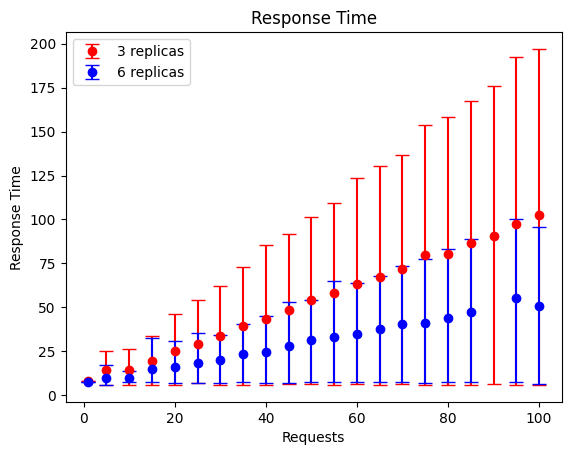

In [30]:
import matplotlib.pyplot as plt
# Extracting values
x = [d["total_requests"] for d in data]
x6 = [d["total_requests"] for d in data6]
# x9 = [d["total_requests"] for d in data9]

y = [d["average_latency"] for d in data]
y6 = [d["average_latency"] for d in data6]
# y9 = [d["average_latency"] for d in data9]

yerr = [
    [y_i - d["min_latency"] for y_i, d in zip(y, data)],  # Lower error
    [d["max_latency"] - y_i for y_i, d in zip(y, data)]   # Upper error
]
yerr6 = [
    [y_i - d["min_latency"] for y_i, d in zip(y6, data6)],  # Lower error
    [d["max_latency"] - y_i for y_i, d in zip(y6, data6)]   # Upper error
]
# yerr9 = [
#     [y_i - d["min_latency"] for y_i, d in zip(y9, data9)],  # Lower error
#     [d["max_latency"] - y_i for y_i, d in zip(y9, data9)]   # Upper error
# ]

# Plotting
plt.errorbar(x, y, yerr=yerr, fmt='o', color='red', ecolor='red', capsize=5, label='3 replicas')
plt.errorbar(x6, y6, yerr=yerr6, fmt='o', color='blue', ecolor='blue', capsize=5, label='6 replicas')
# plt.errorbar(x9, y9, yerr=yerr9, fmt='o', color='green', ecolor='green', capsize=5, label='9 replicas')

# plt.plot(x, y, color='red', linestyle='-', linewidth=2)
# plt.plot(x6, y6, color='blue', linestyle='-', linewidth=2)
# plt.plot(x9, y9, color='green', linestyle='-', linewidth=2)
# Adding labels and title
plt.xlabel('Requests')
plt.ylabel('Response Time')
plt.title('Response Time')
plt.legend()

# Displaying the plot
plt.show()